In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import openai
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain_community.retrievers import BM25Retriever
from pprint import pprint
import tiktoken
import numpy as np
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from constants import OPENAI_EMBEDDDINGS, TIKTOKEN_MODEL, RETRIEVER_TOP_K, YEAR, LLM_MODEL, LLM_TEMPERATURE, CHUNK_SIZE, CHUNK_OVERLAP
from dotenv import load_dotenv
import os
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.chains import create_retrieval_chain
from langchain_core.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_core.vectorstores import VectorStoreRetriever

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

## Data load in spark

#### The corpus https://huggingface.co/datasets/eloukas/edgar-corpus does not contain tabular data as specified in the original paper. For this purpose, the crawler from https://github.com/lefterisloukas/edgar-crawler was used to extract the 10-K data for AIG (cik - 5272) for the years ranging from 2007 to 2022. 

In [3]:
spark = SparkSession.builder \
    .appName("ReadGCSParquet") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/17 02:03:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/17 02:03:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
df = spark.read.option("multiLine", True).json("data/10-K/*.json")

In [5]:
# List out all the columns in the dataframe
df.printSchema()

root
 |-- cik: string (nullable = true)
 |-- company: string (nullable = true)
 |-- complete_text_filing_link: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- filing_date: string (nullable = true)
 |-- filing_html_index: string (nullable = true)
 |-- filing_type: string (nullable = true)
 |-- fiscal_year_end: string (nullable = true)
 |-- htm_filing_link: string (nullable = true)
 |-- item_1: string (nullable = true)
 |-- item_10: string (nullable = true)
 |-- item_11: string (nullable = true)
 |-- item_12: string (nullable = true)
 |-- item_13: string (nullable = true)
 |-- item_14: string (nullable = true)
 |-- item_15: string (nullable = true)
 |-- item_16: string (nullable = true)
 |-- item_1A: string (nullable = true)
 |-- item_1B: string (nullable = true)
 |-- item_1C: string (nullable = true)
 |-- item_2: string (nullable = true)
 |-- item_3: string (nullable = true)
 |-- item_4: string (nullable = true)
 |-- item_5: string (nullable = true)
 |-- item_6: st

In [6]:
# Use the columns related to the different items in the 10-K form along with period of report
cols_to_use = ['item_1','item_1A','item_1B','item_1C','item_2','item_3','item_4',
               'item_5','item_6','item_7','item_7A','item_8','item_9A','item_9B','item_9C',
              'item_10','item_11','item_12','item_13','item_14','item_15','item_16','period_of_report']
# Store the data in a pandas dataframe
df_pd = pd.DataFrame(df.collect(),columns=df.columns)
# Filter the dataframe 
df_pd_filt = df_pd[[c for c in cols_to_use]]

25/09/17 02:03:29 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Exploratory data analysis

#### Length of sections

In [7]:
def convert_to_df(x_dict):
    """
    Method to convert dictionary to pandas dataframe
    Args:
            x_dict (dict): Dictionary containing keys and values.

        Returns:
            pd.DataFrame: Dataframe with keys as columns and values as rows.
    """
    df = pd.DataFrame(x_dict, index=[0])
    return df

In [8]:
col_len={}
for col in df_pd_filt.columns:
    col_len[col] = np.mean(df_pd_filt[col].str.len())

df_col_stats = convert_to_df(col_len)

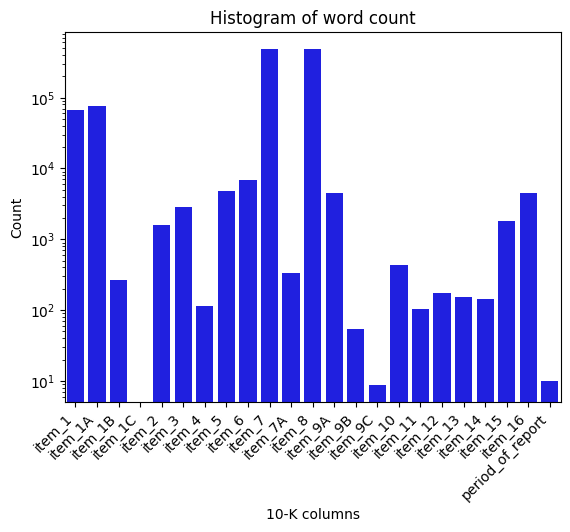

In [9]:
# Plot the histogram of the word count
sns.barplot(data = df_col_stats, color='blue')
plt.xticks(rotation=45, ha="right")
plt.yscale('log')
plt.xlabel('10-K columns')
plt.ylabel('Count')
plt.title('Histogram of word count')
plt.show()

### Token distribution

In [10]:
enc = tiktoken.encoding_for_model(TIKTOKEN_MODEL)
enc.encode(df_pd_filt.loc[0,col])
col_token_len={}
for col in df_pd_filt.columns:
    col_token_len[col] = np.round(np.mean([len(t) for t in enc.encode_batch(df_pd_filt[col])]))

df_col_token_stats = convert_to_df(col_len)


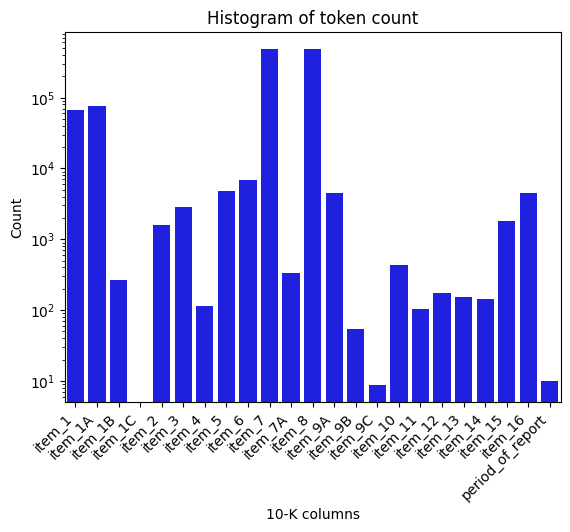

In [11]:
# Plot the histogram of the tokens
sns.barplot(data = df_col_token_stats, color='blue')
plt.xticks(rotation=45, ha="right")
plt.yscale('log')
plt.xlabel('10-K columns')
plt.ylabel('Count')
plt.title('Histogram of token count')
plt.show()

### Filter the data to a specific year

In [12]:
df_pd_filt_yr = df_pd_filt[pd.to_datetime(df_pd_filt['period_of_report']).dt.year==YEAR]

# RAG development

In [13]:
def get_metadata_text(x):
    """
    Method to extract the metadata from the text
    """
    if 'ITEM' in x[:10]:
        return x.split('/')[1].split('\n')[0].strip(' ')
    else:
        return ''

In [14]:
# Create Document objects from the text and store the metadata associated with it.
documents=[]
for i,row in df_pd_filt_yr.iterrows():
    for col in df_pd_filt_yr.columns:
        documents.append(Document(row[col], metadata={'year':row['period_of_report'],
                                                     'section':col,
                                                     'description':get_metadata_text(row[col])}))

In [15]:
# Use the character text splitter to create chunks of the given size with appropriate overlap
splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
split_doc = splitter.split_documents(documents)

In [16]:
# Retriever using GPT-5 embeddings from OpenAI
embeddings = OpenAIEmbeddings(model=OPENAI_EMBEDDDINGS)
vector_store = InMemoryVectorStore(embeddings)
ids = vector_store.add_documents(documents=split_doc)
# Retriever with top K retrieval
retriever = vector_store.as_retriever(search_kwargs={"k": RETRIEVER_TOP_K})


In [17]:
# RAG pipeline


# Define LLM object
llm = ChatOpenAI(
    model=LLM_MODEL,
    temperature=LLM_TEMPERATURE,
)


# Document prompt that uses the metadata and the page content from the documents
document_prompt = PromptTemplate.from_template(
    "Year: {year}\nSection: {section}\nDescription: {description}\nContent: {page_content}"
)

# System prompt to the LLM
system_prompt = (
    "You are a data extractor of financial documents like 10-K filed by companies."
    "Analyze the data carefully without making up data."
    "If you don't know the answer, say you don't know. "
    "For section provide the appropriate section answer."
    "Keep the data concise and generate it in a CSV format"
    "If any text data contains a comma then remove it"
    "Based on the question asked provide a tabular response when possible.\n\n"
    "Context: {context}"
)

# Prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "{input}")
])

# QA chain connecting LLM to the prompt
question_answer_chain = create_stuff_documents_chain(llm, prompt, document_prompt=document_prompt, document_variable_name="context")

# Retrieval chain connecting the retriever object to the QA chain
chain = create_retrieval_chain(retriever, question_answer_chain)



In [18]:
def convert_resp_df(resp):
    """
    Method to convert LLM response to dataframe
    """
    resp_header = [t.split(',') for t in resp.split('\n')][0]
    resp_data = [t.split(',') for t in resp.split('\n')][1:]
    resp_df = pd.DataFrame(resp_data, columns=resp_header)
    return resp_df

### Get total revenues

In [19]:
query = "What are the total revenues from 2008 to 2012? Which section of the document is this from?"

response = chain.invoke({"input": query})

df_rev = convert_resp_df(response['answer'])

print(df_rev)

   Year Total Revenues USD millions                         Section
0  2012                       65656  Item 6 Selected Financial Data
1  2011                       59812  Item 6 Selected Financial Data
2  2010                       72829  Item 6 Selected Financial Data
3  2009                       70173  Item 6 Selected Financial Data
4  2008                      -11777  Item 6 Selected Financial Data


### Get undiscounted net reserves from multiple years

In [20]:
query = "What are the undiscounted net reserves from 2004, 2007, 2008, 2010, 2012? Which section of the document is this from?"

response = chain.invoke({"input": query})

df_reserves = convert_resp_df(response['answer'])

print(df_reserves)

   year net_reserves_held_undiscounted_millions_usd section description
0  2004                                       48806  item_1    BUSINESS
1  2007                                       71717  item_1    BUSINESS
2  2008                                       75029  item_1    BUSINESS
3  2010                                       74724  item_1    BUSINESS
4  2012                                       72028  item_1    BUSINESS


### Get securities data

In [ ]:
query = "List the top 5 available-for-sale securities by fair value? Which section of the document is this from?"

response = chain.invoke({"input": query})

df_sec = convert_resp_df(response['answer'])

print(df_sec)

## Read from ground truth

 Ground truth data was generated from the 10-K for the year specified in the constants.py file.  

In [ ]:
df_rev_gt = pd.read_csv('data/total_revenues.csv')
df_reserve_gt = pd.read_csv('data/undisclosed_reserves.csv')
df_securities_gt = pd.read_csv('data/securities.csv')

In [ ]:
df_rev['Year'] = df_rev['Year'].astype(int)
df_reserves['Year'] = df_reserves['Year'].astype(int)


In [ ]:
df_rev_comb = df_rev.merge(df_rev_gt, left_on='Year', right_on='year', how='inner')
df_rev_comb.to_csv('results/revenue_results.csv', index=False)

In [ ]:
df_rev_comb

**As can be seen from the above joined table, there is an exact match between the total revenues for the years 2008-2012.**

In [ ]:
df_reserves_comb = df_reserves.merge(df_reserve_gt, left_on='Year', right_on='year', how='inner')
df_reserves_comb.to_csv('results/reserves_results.csv', index=False)

In [ ]:
df_reserves_comb

**As can be seen from the merged table there is an exact match for the undisclosed net reserves for multiple non-consecutive years.**

In [ ]:
df_sec_comb = df_sec.merge(df_securities_gt, left_on='Security', right_on='security category', how='outer')
df_sec_comb.to_csv('results/securities_results.csv', index=False)

In [ ]:
df_sec_comb

**We can see that there is a mismatch for Obligations of states, municipalities and political subdvisions and that is because of the fact that the comma was removed from the generated text to esnure that there is no delimiter issue while creating the dataframe. One way to alleviate it would be to do either a fuzzy match of the strings or use embedding based approach to correct it.**